In [1]:
import scipy.optimize
from src.python.getMatrix import getMatrixByName
from src.python.vis.visMat import visMat
from src.python.vis.visGraph import visGraph
from src.python.spring_layout import spring_layout
import networkx as nx
import numpy as np
import scipy.sparse
import time

(936, 936) 6264 float64 1.0 1.0


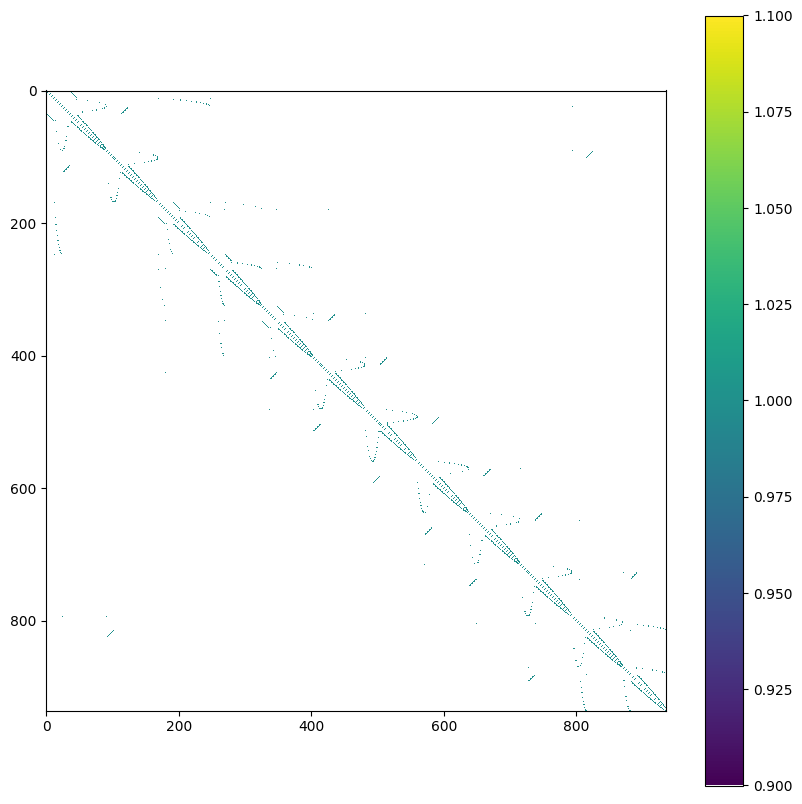

cost(pos,A,k)=np.float64(1882.4943651597616)
cost(pos,A,k)=np.float64(1682.5491043017585)
cost(pos,A,k)=np.float64(1456.7525692758609)
cost(pos,A,k)=np.float64(1265.3332229588461)
cost(pos,A,k)=np.float64(1108.8945632303457)
cost(pos,A,k)=np.float64(986.3720986346799)
cost(pos,A,k)=np.float64(887.5236709299437)
cost(pos,A,k)=np.float64(805.8613640708817)
cost(pos,A,k)=np.float64(736.4411759769042)
cost(pos,A,k)=np.float64(678.1278271140416)
cost(pos,A,k)=np.float64(629.3112493984884)
cost(pos,A,k)=np.float64(586.9723205801282)
cost(pos,A,k)=np.float64(550.3107332401872)
cost(pos,A,k)=np.float64(516.9674403543871)
cost(pos,A,k)=np.float64(486.80273175316466)
cost(pos,A,k)=np.float64(460.2663598506192)
cost(pos,A,k)=np.float64(435.2646478731415)
cost(pos,A,k)=np.float64(412.60686399720566)
cost(pos,A,k)=np.float64(391.47244317937407)
cost(pos,A,k)=np.float64(371.48256099084625)
cost(pos,A,k)=np.float64(352.16633905908446)
cost(pos,A,k)=np.float64(333.860486417812)
cost(pos,A,k)=np.float6

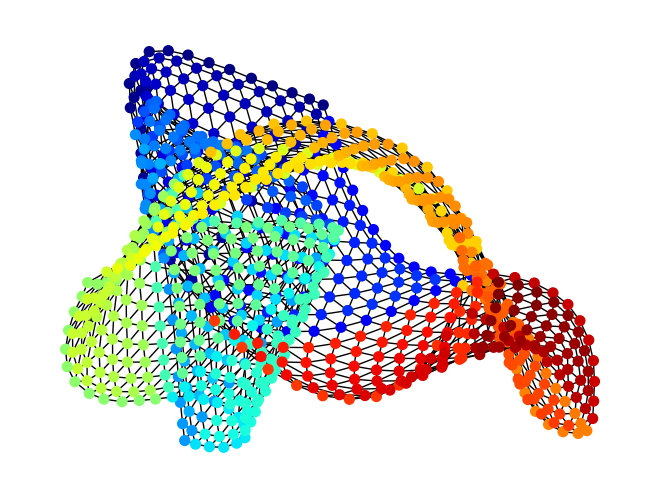

In [2]:
mat = getMatrixByName("jagmesh1")
print(mat.shape, mat.nnz, mat.dtype, np.min(mat.data), np.max(mat.data))

if scipy.sparse.issparse(mat):
    mat.setdiag(0)
    mat.eliminate_zeros()
    mat.data = np.abs(mat.data)
else:
    mat[np.diag_indices_from(mat)] = 0
    mat.data = np.abs(mat.data)

visMat(mat)


G = nx.Graph(mat)

# for pos in spring_layout(G, method="RS", iterations=50):
#     visGraph(G, pos)
visGraph(G, list(spring_layout(G, method="RS", iterations=50))[-1])

In [3]:
x = np.array([2, 0])
y = np.array([[1, 2, 3], [4, 5, 6]]).T
print(x)
print(y)
x - y

[2 0]
[[1 4]
 [2 5]
 [3 6]]


array([[ 1, -4],
       [ 0, -5],
       [-1, -6]])

In [4]:
# for method in [
#     "circular_layout",
#     "kamada_kawai_layout",
#     "random_layout",
#     "shell_layout",
#     "spring_layout",
#     "spectral_layout",
#     "planar_layout",
#     "spiral_layout",
#     "arf_layout",
# ]:
#     print(method)
#     t0 = time.perf_counter()
#     pos = getattr(nx, method)(G)
#     print(f"{time.perf_counter() - t0:.3f} [sec]")
#     visGraph(G, pos)

In [5]:
import numpy as np

a = np.random.random((2, 3))
b = np.random.random((2, 3))

print(np.sum(a * b))
print(np.dot(a.flatten(), b.flatten()))

0.9042961447966191
0.904296144796619
